# Neural network - (ResNet34) 

In [ ]:
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

First we preprocess our data by Normalizing and generate data loaders.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet34(pretrained=True)

Training of the NN

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_history = []
    validation_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # For each iteration- training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # if train: hist
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass 
                    #if train: optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_history.append(epoch_loss)
            else:
                validation_history.append(epoch_loss) 
                
                
           
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_history,validation_history

Defining our hyperparameters and setting optimizer as stochastic gradient descent.

In [ ]:
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft,t,v = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5688 Acc: 0.7000
val Loss: 0.1014 Acc: 1.0000

Epoch 1/19
----------
train Loss: 0.5115 Acc: 0.7833
val Loss: 0.0277 Acc: 1.0000

Epoch 2/19
----------
train Loss: 0.4801 Acc: 0.7667
val Loss: 0.1336 Acc: 0.9167

Epoch 3/19
----------
train Loss: 0.4469 Acc: 0.8333
val Loss: 0.0092 Acc: 1.0000

Epoch 4/19
----------
train Loss: 0.2432 Acc: 0.8833
val Loss: 0.0315 Acc: 1.0000

Epoch 5/19
----------
train Loss: 0.3563 Acc: 0.8667
val Loss: 0.0082 Acc: 1.0000

Epoch 6/19
----------
train Loss: 0.5225 Acc: 0.7667
val Loss: 0.0709 Acc: 1.0000

Epoch 7/19
----------
train Loss: 0.4353 Acc: 0.8667
val Loss: 0.0471 Acc: 1.0000

Epoch 8/19
----------
train Loss: 0.2055 Acc: 0.9500
val Loss: 0.0154 Acc: 1.0000

Epoch 9/19
----------
train Loss: 0.2851 Acc: 0.8833
val Loss: 0.0046 Acc: 1.0000

Epoch 10/19
----------
train Loss: 0.1706 Acc: 0.9167
val Loss: 0.0065 Acc: 1.0000

Epoch 11/19
----------
train Loss: 0.1815 Acc: 0.9000
val Loss: 0.0049 Acc: 1.0000

Ep

**Final Validation Accuracy : 100%**

**Final Training Accuracy : 93.33%**

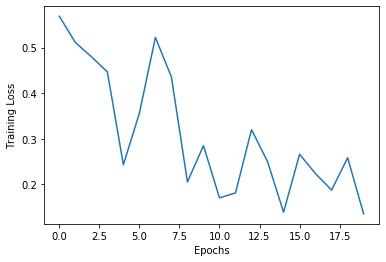

In [ ]:
epochs=[i for i in range(20)]
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(epochs,t)

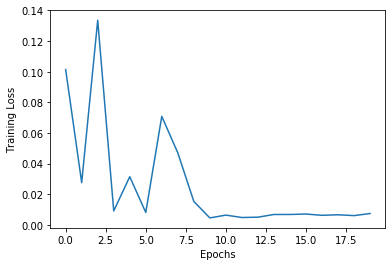

In [ ]:
epochs=[i for i in range(20)]
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(epochs,v)